In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

In [38]:
train_ti_ids = next(os.walk("/content/gdrive/My Drive/MonuSeg/Training/TissueImages/"))[2] # list of names all images in the given path
print("No. of images = ", len(train_ti_ids))

train_gt_ids = []

for i in range( len(train_ti_ids) ):
    #print(i)
    #print( train_ti_ids[i] )
    my_str = train_ti_ids[i]
    substr = ".png"
    inserttxt = "_bin_mask"
    idx = my_str.index(substr)
    my_str = my_str[:idx] + inserttxt + my_str[idx:]
    train_gt_ids.append(my_str)
    #print(my_str)

No. of images =  30


In [39]:
test_ti_ids = next(os.walk("/content/gdrive/My Drive/MonuSeg/Test/TissueImages/"))[2] # list of names all images in the given path
print("No. of images = ", len(test_ti_ids))

test_gt_ids = []

for i in range( len(test_ti_ids) ):
    #print(i)
    #print( test_ti_ids[i] )
    my_str = test_ti_ids[i]
    substr = ".tif"
    inserttxt = "_bin_mask"
    idx = my_str.index(substr)
    my_str = my_str[:idx] + inserttxt + ".png"
    test_gt_ids.append(my_str)
    #print(my_str)

No. of images =  14


In [0]:
def con_img_array(ids, base_path):
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    for i in (range(len(ids))):
        #print(ids[i])
        img = load_img( base_path + ids[i] , color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
        X[i] = x_img/255.0
    #print("=========================================")
    return X


X_train = con_img_array(train_ti_ids, "/content/gdrive/My Drive/MonuSeg/Training/TissueImages/")
y_train = con_img_array(train_gt_ids, "/content/gdrive/My Drive/MonuSeg/Training/GroundTruth/")
X_test = con_img_array(test_ti_ids, "/content/gdrive/My Drive/MonuSeg/Test/TissueImages/")
y_test = con_img_array(test_gt_ids, "/content/gdrive/My Drive/MonuSeg/Test/GroundTruth/")

Text(0.5, 1.0, 'GroundTruth')

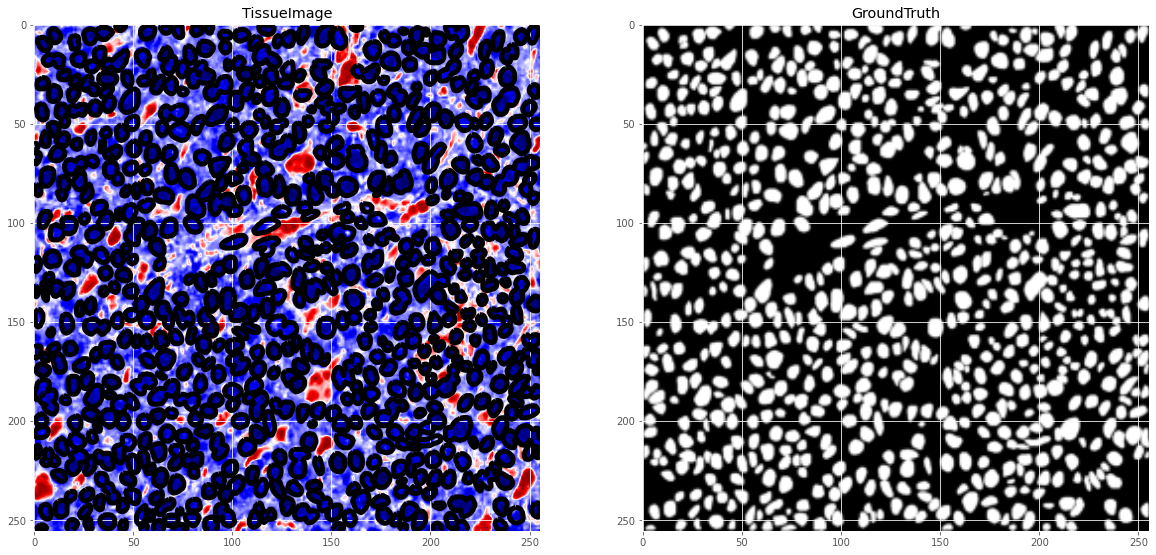

In [41]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TissueImage')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


binary_crossentropy = "binary_crossentropy"


input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=[binary_crossentropy], metrics=["accuracy", f1_m, precision_m, recall_m, dice_coef])

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', save_best_only=True, save_weights_only=True, verbose=1)
]

In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 256, 16) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [47]:
results = model.fit(X_train, y_train, batch_size=32, 
                    epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), verbose = 1)

Train on 30 samples, validate on 14 samples
Epoch 1/50
30/30 [==============================] - 21s 716ms/step - loss: 0.8955 - acc: 0.1627 - f1_m: 0.3268 - precision_m: 0.2236 - recall_m: 0.6068 - dice_coef: 0.8112 - val_loss: 0.8968 - val_acc: 0.2219 - val_f1_m: 0.3140 - val_precision_m: 0.2007 - val_recall_m: 0.7205 - val_dice_coef: 0.8023

Epoch 00001: val_loss improved from inf to 0.89680, saving model to model-tgs-salt.h5
Epoch 2/50
30/30 [==============================] - 18s 615ms/step - loss: 0.8499 - acc: 0.1942 - f1_m: 0.3663 - precision_m: 0.2516 - recall_m: 0.6734 - dice_coef: 0.8208 - val_loss: 0.8509 - val_acc: 0.2662 - val_f1_m: 0.3570 - val_precision_m: 0.2309 - val_recall_m: 0.7860 - val_dice_coef: 0.8146

Epoch 00002: val_loss improved from 0.89680 to 0.85088, saving model to model-tgs-salt.h5
Epoch 3/50
30/30 [==============================] - 18s 604ms/step - loss: 0.8099 - acc: 0.2300 - f1_m: 0.4038 - precision_m: 0.2804 - recall_m: 0.7213 - dice_coef: 0.8308 - va

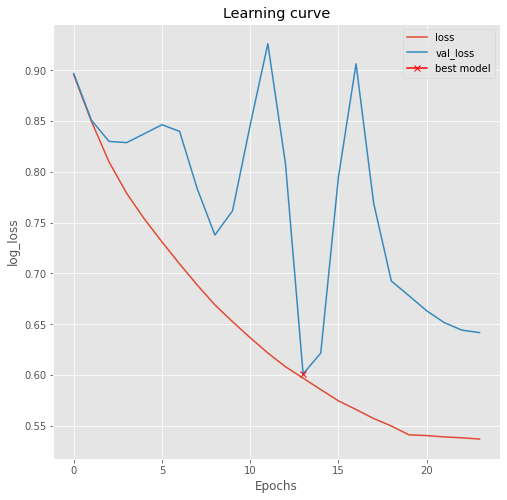

In [48]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig("unet_loss.png")

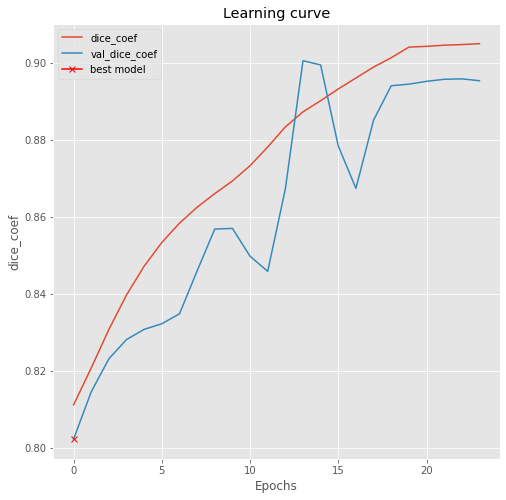

In [49]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig("unet_dice_coef.png")

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [51]:
# Evaluate on validation set (this must be equals to the best log_loss)
loss, accuracy, f1_score, precision, recall , dice_score = model.evaluate(X_test, y_test, verbose=1)

print("unet_loss:", loss)
print("unet_Accuracy:", accuracy)
print("unet_f1_score:", f1_score)
print("unet_dice_score:", dice_score)


14/14 [==============================] - 2s 147ms/step
unet_loss: 0.6011309623718262
unet_Accuracy: 0.4437364935874939
unet_f1_score: 0.5669813752174377
unet_dice_score: 0.9006365537643433


In [52]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 2s 141ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue Images')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Ground Truth Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Ground Truth Predicted binary');

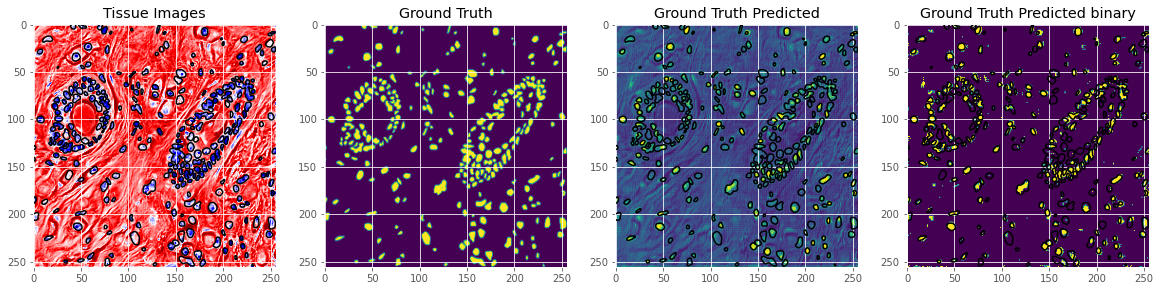

In [55]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

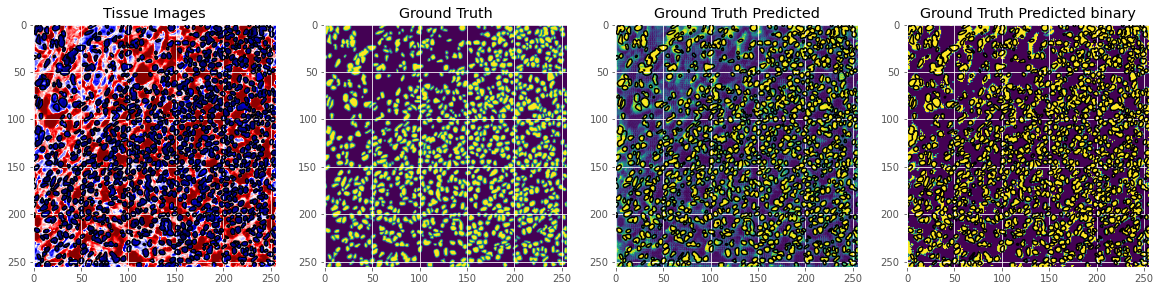

In [56]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

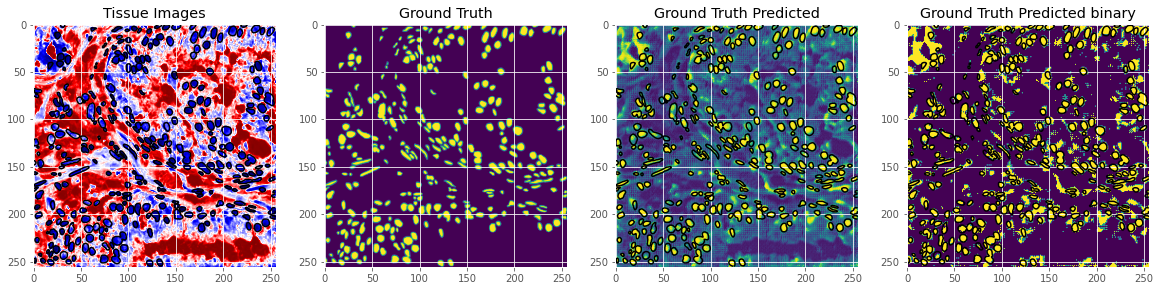

In [57]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

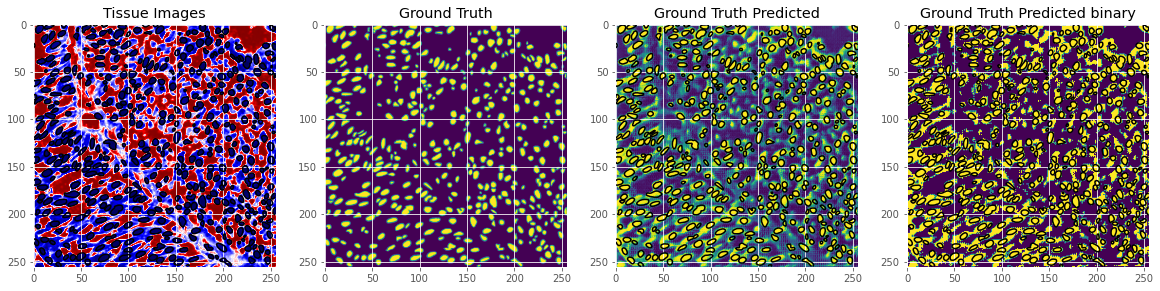

In [58]:
plot_sample(X_test, y_test, preds_test, preds_test_t)